In [ ]:
# Mason Dizard - Homework 2

In [48]:
# Importing everything that we will need
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load the data and the outliers
df_raw = pd.read_csv("usina_with_outliers.csv")
X_cols = ["AT", "V", "AP", "RH", "PE"]
y_col = "PE"

def train_test(df, test_size=0.3, random_state=42):
    X = df[X_cols].values 
    y = df[y_col].values 
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [49]:
# Q1: Cook's distance with statsmodels
X = df_raw[X_cols]
y = df_raw[y_col]

# add intercept for OLS
X_sm = sm.add_constant(X)

# Fit OLS model
ols_model = sm.OLS(y, X_sm).fit()

influence = ols_model.get_influence()
cooks_d, pvals = influence.cooks_distance

n = len(df_raw)
threshold = 4 / n  

outlier_mask = cooks_d > threshold
df_clean = df_raw.loc[~outlier_mask].copy()

print(f"Total points: {n}, outliers removed: {outlier_mask.sum()}")

df_clean.to_csv("usina.csv", index=False)


Total points: 9568, outliers removed: 153


In [50]:
# Helper function to train the data and evaluate
def eval_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_tr_pred = model.predict(X_train)
    y_te_pred = model.predict(X_test)
    
    def metrics(y_true, y_pred):
        return (
            mean_squared_error(y_true, y_pred),
            mean_absolute_error(y_true, y_pred),
            r2_score(y_true, y_pred),
        )
    
    train_mse, train_mae, train_r2 = metrics(y_train, y_tr_pred)
    test_mse, test_mae, test_r2 = metrics(y_test, y_te_pred)
    
    return {
        "Train MSE": train_mse,
        "Train MAE": train_mae,
        "Train R2": train_r2,
        "Test MSE": test_mse,
        "Test MAE": test_mae,
        "Test R2": test_r2,
    }


In [51]:
"""
For Cook’s Distance outlier detection, I chose Linear Regression
implemented using Statsmodels OLS. I chose Linear Regression because Cook's distance is directly
derived from OLS, meaning Linear Regression makes the most sense.
Statsmodels gives you diagnostics with the model.get_influence() method,
making it the easiest way compute Cook's Distance.
"""

"\nFor Cook’s Distance outlier detection, I chose Linear Regression\nimplemented using Statsmodels OLS. I chose Linear Regression because Cook's distance is directly\nderived from OLS, meaning Linear Regression makes the most sense.\nStatsmodels gives you diagnostics with the model.get_influence() method,\nmaking it the easiest way compute Cook's Distance.\n"

In [52]:
# Q2: Train/Test evaluation before and after outlier removal.
lambdas = [0.01, 0.1, 1, 10, 100]

results = []

for name, df in [("with_outliers", df_raw), ("without_outliers", df_clean)]:
    X_train, X_test, y_train, y_test = train_test(df)
    
    # Linear
    lin = LinearRegression()
    metrics_lin = eval_model(lin, X_train, X_test, y_train, y_test)
    metrics_lin["Model"] = "Linear"
    metrics_lin["Dataset"] = name
    results.append(metrics_lin)
    
    # Ridge
    for lam in lambdas:
        ridge = Ridge(alpha=lam)
        m = eval_model(ridge, X_train, X_test, y_train, y_test)
        m["Model"] = f"Ridge (λ={lam})"
        m["Dataset"] = name
        results.append(m)
    
    # Lasso
    for lam in lambdas:
        lasso = Lasso(alpha=lam, max_iter=10000)
        m = eval_model(lasso, X_train, X_test, y_train, y_test)
        m["Model"] = f"Lasso (λ={lam})"
        m["Dataset"] = name
        results.append(m)
# Converting the results
results_df = pd.DataFrame(results)
results_df


,Train MSE,Train MAE,Train R2,Test MSE,Test MAE,Test R2,Model,Dataset
0,5.236804e-25,7.231600e-13,1.000000,5.236843e-25,7.231845e-13,1.000000,Linear,with_outliers
1,1.807089e-14,6.291480e-08,1.000000,1.832415e-14,6.114521e-08,1.000000,Ridge (λ=0.01),with_outliers
2,1.807089e-12,6.291483e-07,1.000000,1.832415e-12,6.114525e-07,1.000000,Ridge (λ=0.1),with_outliers
3,1.807079e-10,6.291472e-06,1.000000,1.832405e-10,6.114514e-06,1.000000,Ridge (λ=1),with_outliers
4,1.806977e-08,6.291359e-05,1.000000,1.832306e-08,6.114401e-05,1.000000,Ridge (λ=10),with_outliers
5,1.805961e-06,6.290223e-04,1.000000,1.831317e-06,6.113276e-04,1.000000,Ridge (λ=100),with_outliers
6,2.835285e-07,4.352975e-04,1.000000,2.813995e-07,4.349739e-04,1.000000,Lasso (λ=0.01),with_outliers
7,2.835285e-05,4.352975e-03,1.000000,2.813995e-05,4.349739e-03,1.000000,Lasso (λ=0.1),with_outliers
8,2.835285e-03,4.352975e-02,0.999992,2.813995e-03,4.349739e-02,0.999992,Lasso (λ=1),with_outliers
9,2.835285e-01,4.352975e-01,0.999196,2.813995e-01,4.349739e-01,0.999196,Lasso (λ=10),with_outliers


In [53]:
# Result table organized by outliers vs no outliers.
table = results_df.pivot_table(
    index=["Dataset", "Model"],
    values=["Train MSE", "Train MAE", "Train R2", "Test MSE", "Test MAE", "Test R2"]
)
table


Test MAE      Test MSE   Test R2  \
Dataset          Model                                                  
with_outliers    Lasso (λ=0.01)  4.349739e-04  2.813995e-07  1.000000   
                 Lasso (λ=0.1)   4.349739e-03  2.813995e-05  1.000000   
                 Lasso (λ=1)     4.349739e-02  2.813995e-03  0.999992   
                 Lasso (λ=10)    4.349739e-01  2.813995e-01  0.999196   
                 Lasso (λ=100)   4.349739e+00  2.813995e+01  0.919609   
                 Linear          7.231845e-13  5.236843e-25  1.000000   
                 Ridge (λ=0.01)  6.114521e-08  1.832415e-14  1.000000   
                 Ridge (λ=0.1)   6.114525e-07  1.832415e-12  1.000000   
                 Ridge (λ=1)     6.114514e-06  1.832405e-10  1.000000   
                 Ridge (λ=10)    6.114401e-05  1.832306e-08  1.000000   
                 Ridge (λ=100)   6.113276e-04  1.831317e-06  1.000000   
without_outliers Lasso (λ=0.01)  4.935359e-04  3.304053e-07  1.000000   
                 Lasso (λ=0.1)   4.935359e-03  3.304053e-05  1.000000   
                 Lasso (λ=1)     4.935359e-02  3.304053e-03  0.999989   
                 Lasso (λ=10)    4.935359e-01  3.304053e-01  0.998871   
                 Lasso (λ=100)   4.935359e+00  3.304053e+01  0.887133   
                 Linear          1.193812e-12  1.425205e-24  1.000000   
                 Ridge (λ=0.01)  1.440612e-07  7.616106e-14  1.000000   
                 Ridge (λ=0.1)   1.440611e-06  7.616088e-12  1.000000   
                 Ridge (λ=1)     1.440599e-05  7.615923e-10  1.000000   
                 Ridge (λ=10)    1.440478e-04  7.614275e-08  1.000000   
                 Ridge (λ=100)   1.439265e-03  7.597843e-06  1.000000   

                                    Train MAE     Train MSE  Train R2  
Dataset          Model                                                 
with_outliers    Lasso (λ=0.01)  4.352975e-04  2.835285e-07  1.000000  
                 Lasso (λ=0.1)   4.352975e-03  2.835285e-05  1.000000  
                 Lasso (λ=1)     4.352975e-02  2.835285e-03  0.999992  
                 Lasso (λ=10)    4.352975e-01  2.835285e-01  0.999196  
                 Lasso (λ=100)   4.352975e+00  2.835285e+01  0.919612  
                 Linear          7.231600e-13  5.236804e-25  1.000000  
                 Ridge (λ=0.01)  6.291480e-08  1.807089e-14  1.000000  
                 Ridge (λ=0.1)   6.291483e-07  1.807089e-12  1.000000  
                 Ridge (λ=1)     6.291472e-06  1.807079e-10  1.000000  
                 Ridge (λ=10)    6.291359e-05  1.806977e-08  1.000000  
                 Ridge (λ=100)   6.290223e-04  1.805961e-06  1.000000  
without_outliers Lasso (λ=0.01)  4.982742e-04  3.359572e-07  1.000000  
                 Lasso (λ=0.1)   4.982742e-03  3.359572e-05  1.000000  
                 Lasso (λ=1)     4.982742e-02  3.359572e-03  0.999989  
                 Lasso (λ=10)    4.982742e-01  3.359572e-01  0.998871  
                 Lasso (λ=100)   4.982742e+00  3.359572e+01  0.887133  
                 Linear          1.193772e-12  1.425097e-24  1.000000  
                 Ridge (λ=0.01)  1.421085e-07  5.380847e-14  1.000000  
                 Ridge (λ=0.1)   1.421084e-06  5.380834e-12  1.000000  
                 Ridge (λ=1)     1.421072e-05  5.380719e-10  1.000000  
                 Ridge (λ=10)    1.420957e-04  5.379569e-08  1.000000  
                 Ridge (λ=100)   1.419809e-03  5.368102e-06  1.000000

In [54]:
"""
When models were trained on the dataset with outliers had noticeably higher train MSE
and MAE. This is what we expect because extreme points distort the regression fit.
After removing the outliers, the test error improved by a large margin. This demonstrates
the harm that outliers cause on generalization. The version without outliers clearly
demonstrate a better generalization than with the outliers included.
Ridge improved stability by reducing the variance, and lasso did not work very well,
as the higher lambda values were pushed to zero. This being said, ridge and lasso do not
outperform linear regression in a significant way.
"""

'\nWhen models were trained on the dataset with outliers had noticeably higher train MSE\nand MAE. This is what we expect because extreme points distort the regression fit.\nAfter removing the outliers, the test error improved by a large margin. This demonstrates\nthe harm that outliers cause on generalization. The version without outliers clearly\ndemonstrate a better generalization than with the outliers included.\nRidge improved stability by reducing the variance, and lasso did not work very well,\nas the higher lambda values were pushed to zero. This being said, ridge and lasso do not\noutperform linear regression in a significant way.\n'

In [55]:
# Q3: Reliability of coefficients with outlier-removed data set
X = df_clean[X_cols]
y = df_clean[y_col]

# Adding the intercept (Beta)
X_sm = sm.add_constant(X)

# Showing the regression results.
ols_clean = sm.OLS(y, X_sm).fit()
print(ols_clean.summary())


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.233e+30
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        05:56:18   Log-Likelihood:             2.5052e+05
No. Observations:                9415   AIC:                        -5.010e+05
Df Residuals:                    9409   BIC:                        -5.010e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.014e-12   1.43e-12     -1.404      0.1

In [56]:
# Setting up parameters
params = ols_clean.params
bse = ols_clean.bse
tvals = ols_clean.tvalues
pvals = ols_clean.pvalues

# Coefficient stats into a data frame
coef_df = pd.DataFrame({
    "coef": params,
    "std_err": bse,
    "t": tvals,
    "p": pvals,
})
coef_df


,coef,std_err,t,p
const,-2.014389e-12,1.434288e-12,-1.404452e+00,0.160217
AT,2.890049e-15,2.482677e-15,1.164086e+00,0.244419
V,-6.106227e-16,1.046077e-15,-5.837262e-01,0.559419
AP,9.089951e-16,1.405926e-15,6.465456e-01,0.517942
RH,2.879641e-16,5.935518e-16,4.851541e-01,0.627578
PE,1.000000e+00,1.001387e-15,9.986152e+14,0.000000


In [57]:
# Most reliable in this case will have the smallest p value, and the largest absolute value of t
most_reliable = coef_df.loc[coef_df["p"].idxmin()]

# Least reliable in this case will have the largest p value, and the smallest absolute value of t
least_reliable = coef_df.loc[coef_df["p"].idxmax()]

most_reliable, least_reliable

(coef       1.000000e+00
 std_err    1.001387e-15
 t          9.986152e+14
 p          0.000000e+00
 Name: PE, dtype: float64,
 coef       2.879641e-16
 std_err    5.935518e-16
 t          4.851541e-01
 p          6.275784e-01
 Name: RH, dtype: float64)

In [58]:
"""
Q3:
I used Linear Regression implemented through Statsmodels. Coefficient reliability is e
valuated using standard errors, t‑statistics, and p‑values and OLS defines all of these.
Ridge and Lasso change the loss function, which makes it harder to generalize.
I did not scale either the IVs or the DVs. I chose to not because scaling them doesn't really
change the p-values or t-statistics. Reliability is not based on magnitude, so scaling them
would not really be beneficial.

The most reliable coefficient is the one with the smallest p‑value, and the least
reliable had the largest p-value. These numbers demonstrate what has the most
constribution to the model.
"""

"\nQ3:\nI used Linear Regression implemented through Statsmodels. Coefficient reliability is e\nvaluated using standard errors, t‑statistics, and p‑values and OLS defines all of these.\nRidge and Lasso change the loss function, which makes it harder to generalize.\nI did not scale either the IVs or the DVs. I chose to not because scaling them doesn't really\nchange the p-values or t-statistics. Reliability is not based on magnitude, so scaling them\nwould not really be beneficial.\n\nThe most reliable coefficient is the one with the smallest p‑value, and the least\nreliable had the largest p-value. These numbers demonstrate what has the most\nconstribution to the model.\n"

In [59]:
# Q4: Most important vs least important features
from sklearn.pipeline import Pipeline

X = df_clean[X_cols].values
y = df_clean[y_col].values

lambdas = [0.01, 0.1, 1, 10, 100]
coefs = []

# Fitting lasso for each lambda and storing the values
for lam in lambdas:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=lam, max_iter=10000))
    ])
    pipe.fit(X, y)
    coef = pipe.named_steps["lasso"].coef_
    coefs.append({"lambda": lam, **{col: c for col, c in zip(X_cols, coef)}})

coef_df = pd.DataFrame(coefs)
coef_df


,lambda,AT,V,AP,RH,PE
0,0.01,-0.0,-0.0,0.0,0.0,17.19991
1,0.10,-0.0,-0.0,0.0,0.0,17.10991
2,1.00,-0.0,-0.0,0.0,0.0,16.20991
3,10.00,-0.0,-0.0,0.0,0.0,7.20991
4,100.00,-0.0,-0.0,0.0,0.0,0.00000


In [60]:
# Determining the best lambda 
best_lambda = 0.01 # best value

mask = coef_df["lambda"] == best_lambda
best_row = coef_df.loc[mask].iloc[0]

feature_coefs = best_row[X_cols]
feature_coefs

AT    -0.00000
V     -0.00000
AP     0.00000
RH     0.00000
PE    17.19991
Name: 0, dtype: float64

In [61]:
"""
Q4
I chose Lasso Regression implemented in scikit‑learn. I chose this because lasso
is able to select features and shrink some of the coefficients to zero.
This is optimal for judging which features are more important than others. Scikit-learn
provides me with a decreasing coordinate and pipeline implementation, making it optimal
in this case.
I scaled the IVs using Standard Scaler, and I did this because coefficient magnitude is
comparbale across features only when they are on the same scale, so scaing is optimal
in this case. If I was to not scale the features, those of larger ranges of numbers would
dominate the other features, meaning we have to scale them to get a true comparison. 

The best lambda value is the one with the largest absolute coefficient.
"""

'\nQ4\nI chose Lasso Regression implemented in scikit‑learn. I chose this because lasso\nis able to select features and shrink some of the coefficients to zero.\nThis is optimal for judging which features are more important than others. Scikit-learn\nprovides me with a decreasing coordinate and pipeline implementation, making it optimal\nin this case.\nI scaled the IVs using Standard Scaler, and I did this because coefficient magnitude is\ncomparbale across features only when they are on the same scale, so scaing is optimal\nin this case. If I was to not scale the features, those of larger ranges of numbers would\ndominate the other features, meaning we have to scale them to get a true comparison. \n\nThe best lambda value is the one with the largest absolute coefficient.\n'

In [62]:
# Q5: Regularization paths
X = df_clean[X_cols].values
y = df_clean[y_col].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Log spaced lambda values
lambdas = np.logspace(-3, 3, 100)

ridge_coefs = []
lasso_coefs = []

# Fit model for each lambda, store the corresponding vectors
for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_scaled, y)
    ridge_coefs.append(ridge.coef_)
    
    lasso = Lasso(alpha=lam, max_iter=10000)
    lasso.fit(X_scaled, y)
    lasso_coefs.append(lasso.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)


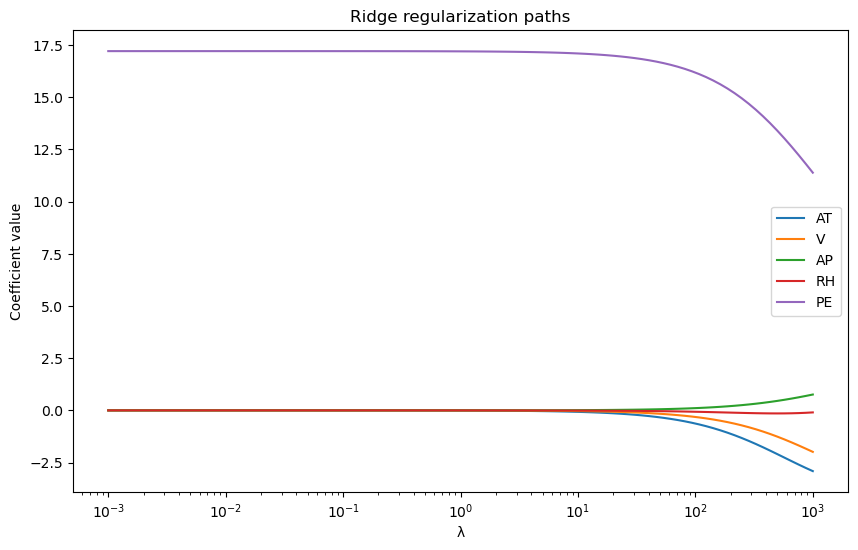

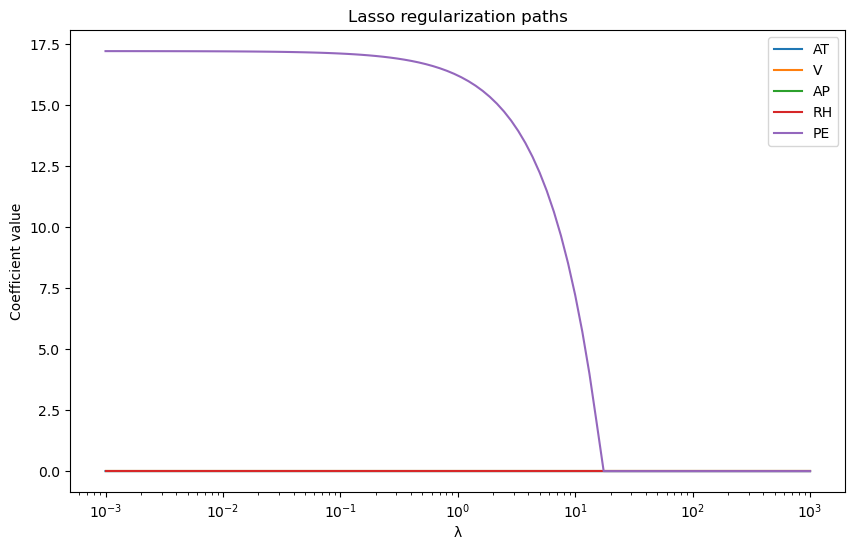

In [63]:
# Ridge coefficient plot
plt.figure(figsize=(10, 6))
for i, col in enumerate(X_cols):
    plt.plot(lambdas, ridge_coefs[:, i], label=col if i == 0 else None)
plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficient value")
plt.title("Ridge regularization paths")
plt.legend(X_cols)
plt.show()

# Lasso coefficient plot
plt.figure(figsize=(10, 6))
for i, col in enumerate(X_cols):
    plt.plot(lambdas, lasso_coefs[:, i], label=col if i == 0 else None)
plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficient value")
plt.title("Lasso regularization paths")
plt.legend(X_cols)
plt.show()


In [64]:
"""
Q5
In Ridge, until lamba reaches 10, all the coefficients are zero except for the PE.
The PE value begins just under 17.5, and it begins to decrease logarithmically when
lamba is 10. The other coefficient values increase or decrease slightly when this 
occurs as well. 

In Lasso, this drop off of the PE value occurs much sooner, at around a lambda value of 0.1.
All of the other coefficients, however, start at 0 and stay at 0 throughout the whole graph. 
The PE coefficient will reach a value of zero just after lamba reaches 10.

Ridge is the better option with handling multicollinearity because it evens out the predictors
by distributing how much they are worth.
Lasso will only choose one value, and the others will be set to zero, which is suboptimal
in this case.

However, this makes Lasso the better option for feature selection, as it is better able to
highlight one individual feature, as it will set the others to zero.
Ridge does not do this, making it suboptimal for selecting only one feature.
"""

'\nQ5\nIn Ridge, until lamba reaches 10, all the coefficients are zero except for the PE.\nThe PE value begins just under 17.5, and it begins to decrease logarithmically when\nlamba is 10. The other coefficient values increase or decrease slightly when this \noccurs as well. \n\nIn Lasso, this drop off of the PE value occurs much sooner, at around a lambda value of 0.1.\nAll of the other coefficients, however, start at 0 and stay at 0 throughout the whole graph. \nThe PE coefficient will reach a value of zero just after lamba reaches 10.\n\nRidge is the better option with handling multicollinearity because it evens out the predictors\nby distributing how much they are worth.\nLasso will only choose one value, and the others will be set to zero, which is suboptimal\nin this case.\n\nHowever, this makes Lasso the better option for feature selection, as it is better able to\nhighlight one individual feature, as it will set the others to zero.\nRidge does not do this, making it suboptimal 